# Financial Derivatives Project

In [1]:
!pip install qutip

In [16]:
import os
import sys

from qutip import *
from qiskit import (
    QuantumCircuit, QuantumRegister, ClassicalRegister, Aer,
    execute
)
from qiskit.tools.visualization import plot_histogram

assert sys.version_info >= (3,5), "Only Python 3.5 or greater supported."

# import state tomography functions
from qiskit.tools.visualization import plot_histogram, plot_state

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [17]:
T = 60/365 # maturity date in # years from time 0
S0 = 2.50 # starting price of derivative at time 0
K = 3.00 # strike price of derivative, can be executed at time T
sigma = 0.3 # volatility of 30%
r = 0.05 # annual interest rate


# pg. 7, equation (35) from paper
def prob_density(x):
    p_j = (1/np.sqrt(2*np.pi*T))*np.exp(-x**2/(2*T))
    return p_j

# pg. 7 equation (36)
def payoff(x):
    v_x = np.maximum(0,(S0*np.exp(sigma*x+r-0.5*sigma**2)*T - K))
    return v_x
payoff(10)

5.295705244926335

Dillon Work April 28th

R|x⟩|0⟩ = |x⟩ (sqrt(1 − v(x)) |0⟩ +􏰒 sqrt(v(x)) |1⟩)

The n + 1 qubit phase estimation unitary is written in terms of F := R(A ⊗ I2), and the simple rotation unitaries Z := I_2n+1 − 2|0^(n+1)⟩⟨0^(n+1)| and V := I2n+1 −2I2n ⊗|1⟩⟨1|.

In [18]:
n = 2 # number of qubits

### building phase estimation unitary F
#R = 
#A = 

#F = R*(tensor(A,qeye(2)))


### rotation unitary 1 
Z = qeye(2**(n+1)) - Qobj(2*np.outer(basis(2**(n+1),0).full(),basis(2**(n+1),0).dag().full()))
Z
### rotation unitary 2
V_2 = tensor(2*qeye(2**n),Qobj(np.outer(basis(n,1).full(),basis(n,1).dag().full())))
V_2.dims = [[8],[8]]
V = qeye(2**(n+1)) -V_2
V

### final amplitude amplification gate
#S = V*U*V
#U = F*Z*F.dag()
#G = U*S


Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[-1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]]

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.]]

Zach Work May 4th Below

The BSM price of a European option is given by equation (33)
$$\Pi = e^{-rT}\mathbb{E_Q}[v(W_T)]$$

In [32]:
import numpy as np
from scipy.stats import norm

# Payoff functionn Eq. (5)
def v(S_T, k=K):
    return max(0, S_T - k)

# Probability Density Eq. 34
def p_T(x,T):
    return (1/np.sqrt(2*np.pi*T))*np.exp(-x**2/(2*T))

# Get discrete sample to compress [-infty, infty] -> [-xmax, xmax]
# Can specify qubits, global n by default
def disc_points(T, sigma, num_stdv, N):
    x_max =  num_stdv * np.sqrt(T)
    xj = []
    delta_x = 2 * x_max/((2 ** N) - 1)
    for j in range(0, 2**N):
        xj.append(-x_max + (j *  delta_x))
    return xj

def norm_disc_probs(xj, T):
    # calculate normalizing constant
    probs = [p_T(a, T) for a in xj]
    c = sum(probs)
    return [p_T(a, T)/c for a in xj]

# Transforms the Zero ket into a superposition of "j"
# Weighted by the square root of the nonrmalized discrete prob.
# May be shape issues later.
def G_on_zero(ndp, N):
    G_out = np.sqrt(ndp[0]) * basis (2 ** N, 0)
    for j in range(1, 2**N):
        psi_j = np.sqrt(ndp[j]) * basis(2 ** N, j)
        G_out = G_out + psi_j
    return G_out.full()

# Find G
# Equation of the form G|0^n>= G_0
# Eq. (35)
def get_G(G_0, N):
    G = np.identity(2 ** N)
    for x in range(0, 2 ** N):
        G[x, 0] = np.real(G_0.item(x, 0))
    return G

# v_euro(x): R->R relating brownian motion to option payoff
# per Eq. (36)
def v_euro(x, s_0 = S0, k = K, sigma = sigma, r = r, t=T):
    return max(0, s_0 * np.exp(sigma * x + (r - 0.5 * sigma * sigma)*t) - k)

# We need some circuit vtilde(j) that takes some state number $j$
# that has a binary representation and transforms it to the output that
# represents the payoff.
# because we have the disc points calculated clasically in integer form we
# can use v_euro. The entire operation is the R gate.




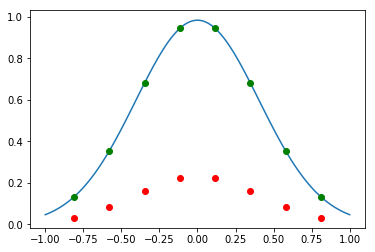

8
dp
[-0.8108848540793832, -0.5792034671995594, -0.34752208031973564, -0.11584069343991188, 0.11584069343991188, 0.34752208031973564, 0.5792034671995594, 0.8108848540793832]
8
Find G_0:
[[0.17747501+0.j]
 [0.28963622+0.j]
 [0.40147945+0.j]
 [0.47268143+0.j]
 [0.47268143+0.j]
 [0.40147945+0.j]
 [0.28963622+0.j]
 [0.17747501+0.j]]
(8, 1)
(0.17747501028006774+0j)
1.0


True

In [33]:
# Testing Functions Defined in [21]

T = 60/365 # maturity date in # years from time 0
S0 = 100 # starting price of derivative at time 0
K = 95 # strike price of derivative, can be executed at time T
sigma = 0.3 # volatility of 30%
r = 0.05 # annual interest rate

n = 3 # number of qubits

# continuous plot resolution
plt_res = 100

# pseudo-continuous distribution
norm_dist = []
rng = np.linspace(-1, 1, plt_res)
for x in rng:
    norm_dist.append(p_T(x, T))
    
plt.plot(rng, norm_dist)

# discrete poinnts
dp = disc_points(T, sigma, 2, n)
dptest = dp

# normalizeed discrete probabilities
norm_probs = norm_disc_probs(dp, T)
nptest = norm_probs

# plot discrete probs
plt.plot(dp, norm_probs, 'ro')

# show original probs for illustration
plt.plot(dp, [(p_T(a, T)) for a in dp], 'go')
plt.show()

print(len(dp))
print("dp")
print(dp)
print(len(norm_probs))

G_0 = G_on_zero(norm_probs, n)
print("Find G_0:")
print(G_0)
print(shape(G_0))
print(G_0[0][0])
# print("Find G st. G|0^n> -> G_0")
G = get_G(G_0, n)
# print(G)

# CHECK
print(sum(norm_probs))

np.allclose(G @ basis(2 ** n , 0).full(), G_0)

In [34]:
# Classical monte carlo estimation to make sure our distro loaded correctly
# Uses Law of Total Probability
pr = 0

# print("DP")
# print(dp)
# print("NormProbs")
# print(norm_probs)

for x in range(len(dp)):
    vj = max(0, S0 * np.exp(sigma * dp[x] + (r - .5 * sigma * sigma)*T) - K)
    pr += vj * norm_probs[x]
print("Classical Monte Carlo Price %f" % pr)
# THIS VALUE SHOULD BE VERY CLOSE TO THE BS VALUE
# Indicates Distro Loaded Correctly

Classical Monte Carlo Price 7.937739


In [35]:
# Eq. (39)
G_on_0 = G @ basis(2 ** n, 0).full()
# Eq. (40)
# list(map(v_euro, dp))

def v(x):
        return max(0, S0 * np.exp((sigma * x) + (r - 0.5 * sigma * sigma)*T) - K)

# Calculate chi per Eq. (40)
# Would be R gate, instead we calculate the value of each state clasically
def get_Chi(G_0, xj, pj, n, v):
    chi_out = tensor((np.sqrt(pj[0]) * basis (2 ** n, 0)),\
        (np.sqrt(1 - v(xj[0] + 0j)) * basis (2,0) + np.sqrt(v(xj[0])) * basis(2,1)))
    for j in range(1, 2 ** n):
        chi_out += tensor((np.sqrt(pj[j]) * basis (2 ** n, j)),\
        (np.sqrt(1 - v(xj[j] + 0j)) * basis (2,0) + np.sqrt(v(xj[j])) * basis(2,1)))
    return chi_out


chi = get_Chi(G_on_0, dp, norm_probs, n, v)
print(chi)

# # Get expectation by measuring chi in state |1>
def mu(chi, n):
    return np.real((chi.dag() * (tensor(qeye(2 **n), basis(2,1) * basis(2,1).dag())) * chi)[0,0])
                        
print(mu(chi, n))
                        
                        
                        
                        

Quantum object: dims = [[8, 2], [1, 1]], shape = (16, 1), type = ket
Qobj data =
[[0.17747501+0.j        ]
 [0.        +0.j        ]
 [0.28963622+0.j        ]
 [0.        +0.j        ]
 [0.40147945+0.j        ]
 [0.        +0.j        ]
 [0.        +0.38513781j]
 [0.60972032+0.j        ]
 [0.        +1.30493j   ]
 [1.38790131+0.j        ]
 [0.        +1.55905305j]
 [1.60991682+0.j        ]
 [0.        +1.39130799j]
 [1.42113583+0.j        ]
 [0.        +0.99837518j]
 [1.01402682+0.j        ]]
7.937738512523552


In [36]:
# One Function to Price Option

def Quantum_Price(S, K, T, r, sigma, qubits):
    def v_euro(x):
        return max(0, S * np.exp((sigma * x) + (r - 0.5 * sigma * sigma)*T) - K)
    dp = disc_points(T, sigma, 2, qubits)
    norm_probs = norm_disc_probs(dp, T)
    G_0 = G_on_zero(norm_probs, qubits)
    chi = get_Chi(G_0, dp, norm_probs, qubits, v_euro)
    eq = mu(chi, qubits)
    return eq * np.e ** (-r * T)

print(Quantum_Price(100, 95, 60/365, 0.05, 0.3, 3))
# print(Quantum_Price(10, 3, 60/365, 0.05, 0.25, 6))
print(bs_price(100, 95, 60/365, 0.05, 0.3))

7.872764209579816
8.150006331239837


In [37]:
# Quantum Binary Arithmetic Utilities Per Appendix C

# We can represent any integere a ≤ N = 2^m with m bits x_i, i =  0,...,m-1
# s.t. a = 2^0(x_0) + 2^1(x_1) + ... + 2^{m-1}(x_{m-1})
# We represent the number a in the basis state |a> = |x_0,...x_{m-1}>
### NOTE PAPER SAYS UP TO x_m but they are incorrect

#We can represent real numbers 0≤r≤1 using m bits b_i, i = 0,...,m-1 s.t.
#  r = b_0/2 + b_1/4 +...+ b_{m-1}/2^m

# For signed numbers utilize an ancillia qubit |s>

# Eq. (C3)
# Zero indexing does not correspond to rail notation in paper
s = QubitCircuit(3)
# cnot target ctrl
s.add_gate("CNOT", 2, 1)
s.add_gate("CNOT", 2, 0)
# Generate Matrix
U_sum = gate_sequence_product(s.propagators())
SUM = U_sum.full()

# Eq. (C4)
# Zero indexing does not correspond to rail notation in paper
cy = QubitCircuit(4)
# NOTE: name tgt ctrl
cy.add_gate("TOFFOLI", 3, [1,2])
cy.add_gate("CNOT", 2,1)
cy.add_gate("TOFFOLI", 3, [0,2])
U_cy = gate_sequence_product(cy.propagators())
CY = U_cy.full()

# print("SUM:")
# print(SUM)
# print("CY:")
# print("CY")

# It can be shown that given some N, we can construct the ADD gate
# which performs addition modulo N, using SUM and CYs see paper Ref.[40]
# However here we opt to implement it using classical tricks.
# FURTHER WORK
# Input 2 numbers < N = 2^m
# Output gate:= |a>|b> -> |a>|a+b mod N>
# Eq. (C6)
# This kinda sucks, but ran out of time
def ADD_N_UTIL(a, b):
    #np array to string
    cry = 0
    out_arr = [0] * len(a[0])
    for x in range(len(a[0])):
        z = int(a[0][x]) + int(b[0][x])
        print(z)
        if cry == 0:
            if z == 2:
                cry = 1
                out_arr[x] = 0
            else:
                out_arr[x] = z
        else:
            z += cry
            if z == 1:
                cry = 0
                out_arr = 1
            elif z == 2:
                cry = 1
                out_arr[x] = 0
            else:
                cry = 1
                out_arr[1]
    return out_arr

#Test ADD_N:
# 6 + 3 =? 1
a = Qobj([[0, 1, 1]]).full()
b = Qobj([[1, 1, 0]]).full()

print(a)

x = ADD_N_UTIL(a, b)
print(x)

[[0.+0.j 1.+0.j 1.+0.j]]
1
2
1
[1, 0, 0]


/Users/Dillon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: ComplexWarning: Casting complex values to real discards the imaginary part


In [38]:
# got this online, forget where, lightly modified

#Simple Black Scholes Estimator for Comparison
def bs_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    call = (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
    
    return call

In [39]:
import time

# Compare quantum algorithm with BS
s = 100
klow = 95
khi = 105
krng = range(klow, khi)
T = 60/365
sigma = 0.25
r = 0.05
qrng = range(4, 9)

b_prices = [0] * len(krng)
q_prices = [[0] * len(krng)] * len(qrng)

for k in krng:
    print("K = %d" % k)
    b_prices[k-klow] = bs_price(s, k, T, r, sigma)
    for q in qrng:
        print("Q = %d"%q)
        q_prices[q-4][k - klow] = Quantum_Price(s, k, T, r, sigma, q)

K = 95
Q = 4
Q = 5
Q = 6
Q = 7
Q = 8
K = 96
Q = 4
Q = 5
Q = 6
Q = 7
Q = 8
K = 97
Q = 4
Q = 5
Q = 6
Q = 7
Q = 8
K = 98
Q = 4
Q = 5
Q = 6
Q = 7
Q = 8
K = 99
Q = 4
Q = 5
Q = 6
Q = 7
Q = 8
K = 100
Q = 4
Q = 5
Q = 6
Q = 7
Q = 8
K = 101
Q = 4
Q = 5
Q = 6
Q = 7
Q = 8
K = 102
Q = 4
Q = 5
Q = 6
Q = 7
Q = 8
K = 103
Q = 4
Q = 5
Q = 6
Q = 7
Q = 8
K = 104
Q = 4
Q = 5
Q = 6
Q = 7
Q = 8


In [ ]:
plt.plot(krng, b_prices)
for i in range(len(qrng)):
    plt.plot(krng, q_prices[i], 'ro')
plt.show()
print(q_prices)